In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
#USER SETTINGS

minInspectedRestos = 10 #number of restos per CB appears biomodal distributed. Eliminating CBs <10 largely eliminates the lower peak of distribution
removeOutliers = False

# Import Data

In [3]:
#Move to correct directory
os.chdir("/Users/karina/Library/CloudStorage/Dropbox/Programming/OTI_Interview")

# Read the CSV files into DataFrames
violationsDfRaw = pd.read_csv("rodentViolationSummary.csv")
complaintsDfRaw = pd.read_csv("rodentComplaintSummary.csv")


In [4]:
#Join Data
violationsDf = violationsDfRaw.rename(columns={'Community Board': 'CB_Id'}, inplace=False)

CB_summary = violationsDf.merge(complaintsDfRaw, on='CB_Id', how='inner')

CB_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   CB_Id               66 non-null     int64
 1   inspected_restos    66 non-null     int64
 2   rodent_viol_restos  66 non-null     int64
 3   complaints          66 non-null     int64
dtypes: int64(4)
memory usage: 2.2 KB


In [5]:
#Add "normalized" columns
CB_summary["complaintsPerInspectedResto"] = CB_summary["complaints"]/CB_summary["inspected_restos"]
CB_summary["violationsPerInspectedResto"] = CB_summary["rodent_viol_restos"]/CB_summary["inspected_restos"]
CB_summary.head()

,CB_Id,inspected_restos,rodent_viol_restos,complaints,complaintsPerInspectedResto,violationsPerInspectedResto
0,101,589,184,207,0.351443,0.312394
1,102,883,387,648,0.733862,0.438279
2,103,944,408,842,0.891949,0.432203
3,104,766,348,664,0.866841,0.454308
4,105,1676,555,238,0.142005,0.331146


# Explore and Clean Data

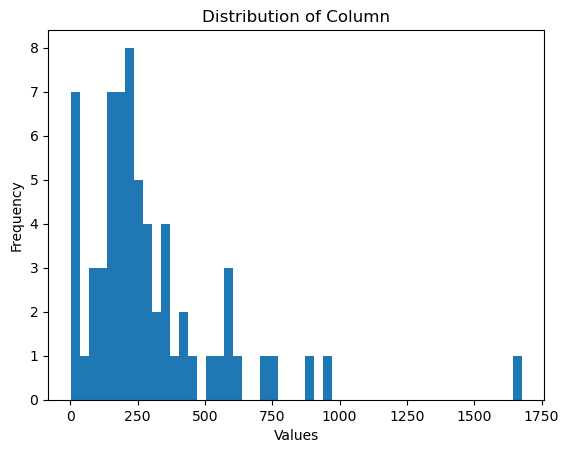

      Consider looking at only CBs with >10 restos and reliminating outlier.
      Would be best to research these CBs first to understand why they don't fit with main population
      and if it makes sense to exclude them from analysis.
      


In [6]:
#Look at distribution of number of restos inspected per community board
#Goal is to get a sense of how similar/different cbs might be and whether it looks like a normal population

plt.hist(CB_summary["inspected_restos"], bins=50)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Column')
plt.show()

print('''WARNING: Distribution of restos inspected appears to be bimodal and with one outlier.
      Consider looking at only CBs with >10 restos and reliminating outlier.
      Would be best to research these CBs first to understand why they don't fit with main population
      and if it makes sense to exclude them from analysis.
      ''')

In [7]:
#(OPTIONAL) Filter out CBs without some minimum number of restaurants inspected
CB_summary_filt = CB_summary[CB_summary["inspected_restos"]>=minInspectedRestos]
print(f'''{CB_summary.shape[0] - CB_summary_filt.shape[0]} rows removed by filtering for
CBs with at least {minInspectedRestos} restos inspected''')

6 rows removed by filtering for
CBs with at least 10 restos inspected


In [8]:
#(OPTIONAL) Filter out outlier CBs in terms of number of restos inspected

if removeOutliers:
    data = CB_summary_filt["inspected_restos"]
    # Calculate quartiles
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    # Calculate IQR
    IQR = Q3 - Q1
    # Define lower and upper bounds
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]

    #Remove outlier rows
    CB_summary_filt=CB_summary_filt[~CB_summary_filt["inspected_restos"].isin(outliers)]

    print(f"Removed outlier CBs with following number of restos inspected:\n{outliers}")
else:
    print("Outlier removal set to off")

Outlier removal set to off


# Fit and plot complaints vs violations (unnormalized)

In [9]:
# Fit linear regression model
X = CB_summary_filt["rodent_viol_restos"].values
y = CB_summary_filt["complaints"].values

lm = LinearRegression()
lm.fit(X.reshape(-1, 1), y.reshape(-1, 1)) #reshape necessary bc lm.fit expects 2D arrays. The -1 just lets program know to infer number of rows from the input, while the 1 says it's one column  
coefficients = lm.coef_[0][0], lm.intercept_[0]

In [10]:
#Get p-value and correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("Correlation coefficient (r):", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

print('''
WARNING!!! The p-value is significant at .05 level when don't filter out any CBs.
Filtering out just outliers lowers p to .0004
Filtering out CBs with <10 restos raises p to .375
Filtering out both raises p to about .07.''')

Slope: 0.5029512466126024
Intercept: 610.8245856774879
Correlation coefficient (r): 0.11649471849982071
P-value: 0.37539913422101057
Standard error: 0.5630391156820135

WARNING!!! The p-value is significant at .05 level when don't filter out any CBs.
Filtering out just outliers lowers p to .0004
Filtering out CBs with <10 restos raises p to .375
Filtering out both raises p to about .07.


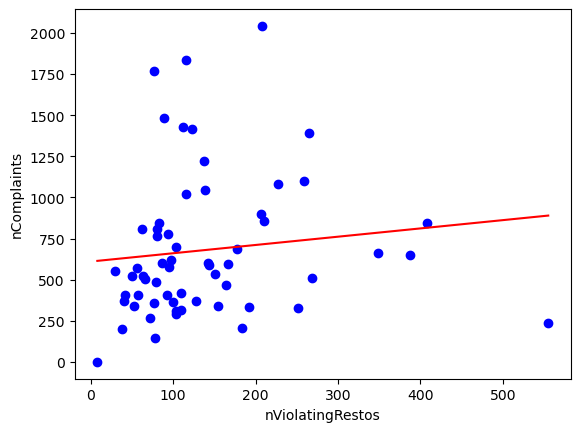

slope: 0.5029512466126024
intercept: 610.8245856774879


In [11]:
# Plot the data points and regression line
plt.figure(1)
plt.plot(CB_summary_filt["rodent_viol_restos"], CB_summary_filt["complaints"], 'ob')
xs = np.array([CB_summary_filt["rodent_viol_restos"].min(),CB_summary_filt["rodent_viol_restos"].max()])
ys = coefficients[0] * xs + coefficients[1]
plt.plot(xs, ys, 'r')
plt.xlabel('nViolatingRestos')
plt.ylabel('nComplaints')
plt.show()
print(f"slope: {coefficients[0]}")
print(f"intercept: {coefficients[1]}")

# Fit and plot complaints vs violations ("normalized")

In [12]:
# Fit linear regression model
X = CB_summary_filt["violationsPerInspectedResto"].values
y = CB_summary_filt["complaintsPerInspectedResto"].values

lm = LinearRegression()
lm.fit(X.reshape(-1, 1), y.reshape(-1, 1)) #reshape necessary bc lm.fit expects 2D arrays. The -1 just lets program know to infer number of rows from the input, while the 1 says it's one column  
coefficients = lm.coef_[0][0], lm.intercept_[0]

In [13]:
#Get p-value and correlation coefficient
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

# Print the results
print("Slope:", slope)
print("Intercept:", intercept)
print("Correlation coefficient (r):", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

print('''
WARNING!!! p-value is NOT significant at .05 level when include all CBs (p = .425).
Filtering out just outliers raises p a bit to 0.547
Filtering out CBs with <10 restos lowers p to .0102
Filtering out both raises p to about .024.''')

Slope: 12.00150335452418
Intercept: -2.399266094478969
Correlation coefficient (r): 0.32943971193717975
P-value: 0.010159952361575002
Standard error: 4.51646806044445

WARNING!!! p-value is NOT significant at .05 level when include all CBs (p = .425).
Filtering out just outliers raises p a bit to 0.547
Filtering out CBs with <10 restos lowers p to .0102
Filtering out both raises p to about .024.


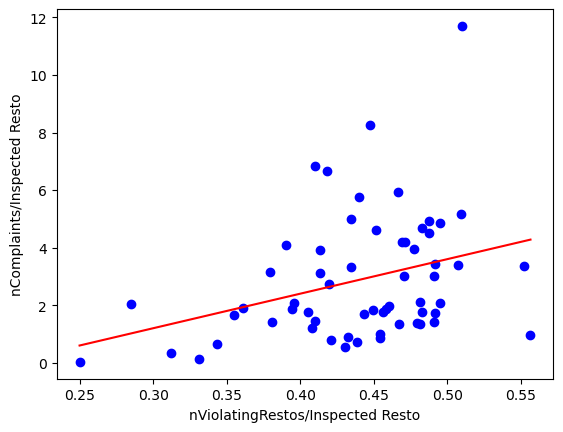

In [14]:
# Plot the data points and regression line
plt.figure(1)
plt.plot(CB_summary_filt["violationsPerInspectedResto"], CB_summary_filt["complaintsPerInspectedResto"], 'ob')
xs = np.array([CB_summary_filt["violationsPerInspectedResto"].min(),CB_summary_filt["violationsPerInspectedResto"].max()])
ys = coefficients[0] * xs + coefficients[1]
plt.plot(xs, ys, 'r')
plt.xlabel('nViolatingRestos/Inspected Resto')
plt.ylabel('nComplaints/Inspected Resto')
plt.show()